EXP_DIR: segformer-rerun-equal-epochs/E1Round1/PushkarA07_segformer-b0-finetuned-net-15Oct
Latest checkpoint: segformer-rerun-equal-epochs/E1Round1/PushkarA07_segformer-b0-finetuned-net-15Oct/checkpoint-438200 step: 438200
device: cuda

Using dataset: PushkarA07/2016-5-A2-dataset-new


Generating test split: 100%|█████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 1687.40 examples/s]


Dataset size: 18
Keys: dict_keys(['pixel_values', 'label'])


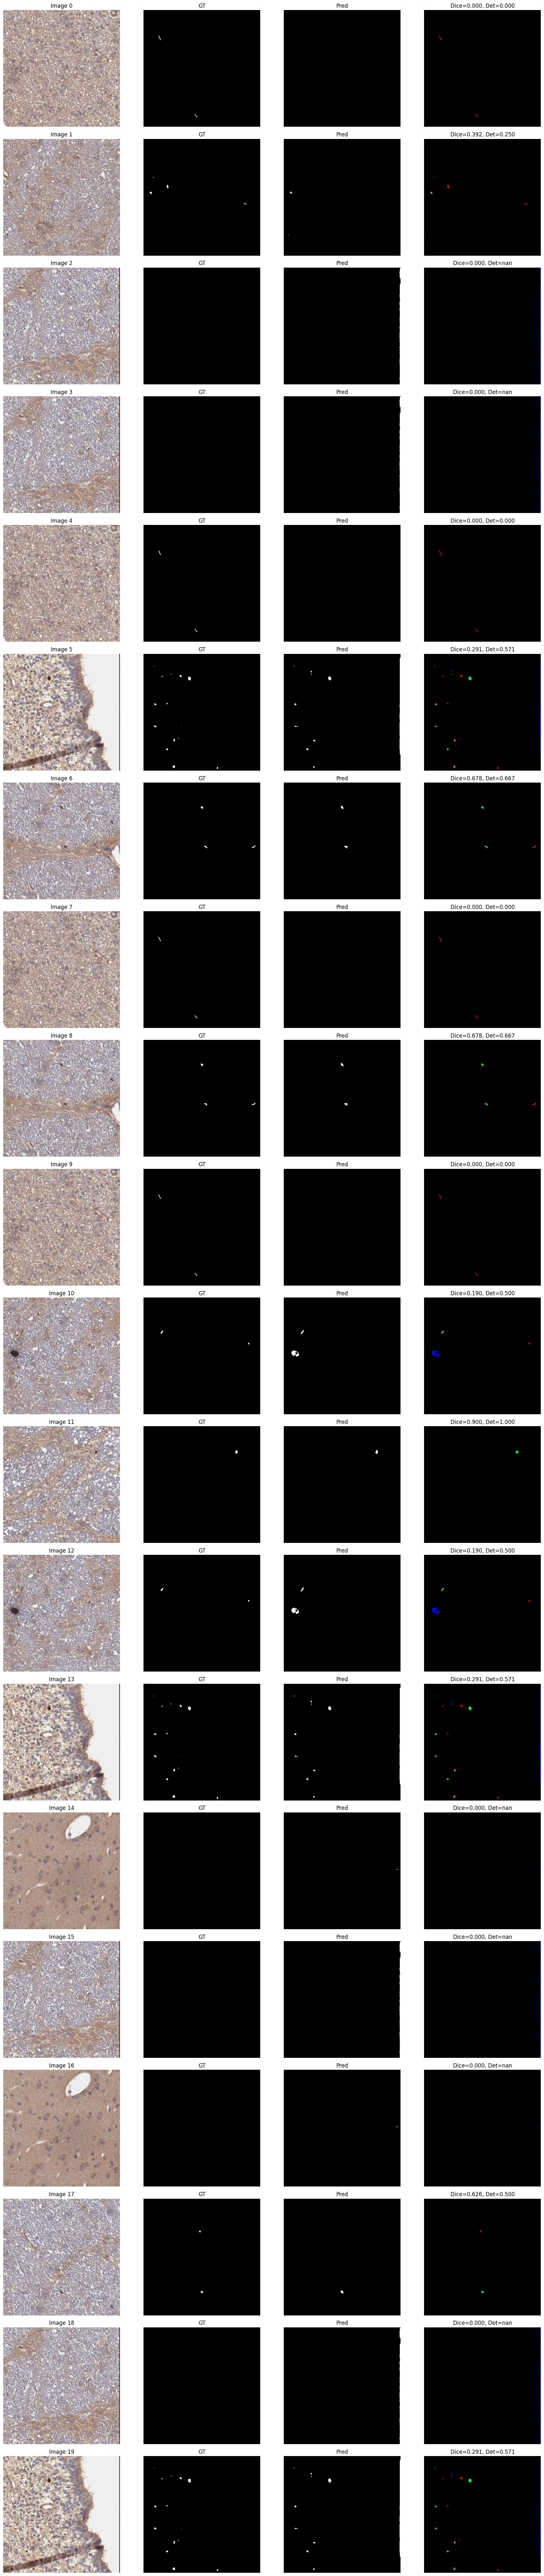


===== SUMMARY =====
Dataset: PushkarA07/2016-5-A2-dataset-new
N used: 25
Mean Dice: 0.23036000680048926
Mean Det : 0.41114292411760767


In [16]:
# ============================================================
# ONE CELL: Load latest checkpoint + test on HF dataset_ids
# - choose dataset from list
# - patch sampling
# - Dice / IoU / Detection rate
# - Error map visualization
# ============================================================

import os, re, random
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2
from PIL import Image

from datasets import load_dataset
from transformers import SegformerForSemanticSegmentation, SegformerImageProcessor

# ===================== EDIT =====================

EXP_DIRS = [
    "segformer-rerun-equal-epochs/E1Round1/PushkarA07_segformer-b0-finetuned-net-15Oct",
    "segformer-rerun-equal-epochs/E1Round2/PushkarA07_segformer-b0-finetuned-net-15Oct",
    "segformer-rerun-equal-epochs/E1Round3/PushkarA07_segformer-b0-finetuned-net-15Oct",
    "segformer-rerun-equal-epochs/Exp3_norm/PushkarA07_segformer-b0-finetuned-net-15Oct",
    "segformer-rerun-equal-epochs/Exp3_unnorm/PushkarA07_segformer-b0-finetuned-net-15Oct",
]
EXP_INDEX = 3  # <-- pick experiment here

DATASET_IDS = [
    "PushkarA07/2017-1-A3-dataset-new",
    "PushkarA07/2016-6-A1-dataset-new",
    "PushkarA07/2016-5-A2-dataset-new",
]

DATASET_INDEX = 2     # <-- choose dataset here
SPLIT = "test"

N_SAMPLES = 25
PATCH = 512
MIN_MASK_PIXELS = 10
MIN_CC_AREA = 1
SEED = 0

# ============================================================

IGNORE = 255

if SEED is not None:
    random.seed(SEED)
    np.random.seed(SEED)
    torch.manual_seed(SEED)

# ---------------- LATEST CHECKPOINT ----------------
def find_latest_checkpoint_recursive(root):
    best_step, best_path = -1, None
    for dirpath, dirnames, _ in os.walk(root):
        for d in dirnames:
            m = re.match(r"checkpoint-(\d+)$", d)
            if m:
                step = int(m.group(1))
                p = os.path.join(dirpath, d)
                if step > best_step:
                    best_step, best_path = step, p
    return best_path, best_step

CKPT_DIR, CKPT_STEP = find_latest_checkpoint_recursive(EXP_DIR)

print("EXP_DIR:", EXP_DIR)
print("Latest checkpoint:", CKPT_DIR, "step:", CKPT_STEP)
assert CKPT_DIR is not None

# ---------------- MODEL ----------------
device = "cuda" if torch.cuda.is_available() else "cpu"
print("device:", device)

processor = SegformerImageProcessor(do_resize=True, do_normalize=True)
model = SegformerForSemanticSegmentation.from_pretrained(
    CKPT_DIR,
    local_files_only=True
).to(device).eval()

# ---------------- DATASET ----------------
DATASET_ID = DATASET_IDS[DATASET_INDEX]
print("\nUsing dataset:", DATASET_ID)

ds = load_dataset(DATASET_ID)[SPLIT]
print("Dataset size:", len(ds))
print("Keys:", ds[0].keys())

# ---------------- HELPERS ----------------
def to_rgb(x):
    return np.array(Image.fromarray(np.uint8(x)).convert("RGB"))

def to_lbl(x):
    x = np.array(Image.fromarray(np.uint8(x)).convert("L"))
    x[(x >= 0) & (x <= 227)] = 0
    x[(x >= 228) & (x <= 255)] = 1
    return x.astype(np.uint8)

def dice_iou_binary(gt, pr, eps=1e-7):
    gt = (gt > 0).astype(np.uint8)
    pr = (pr > 0).astype(np.uint8)
    inter = (gt & pr).sum()
    union = gt.sum() + pr.sum() - inter
    dice = (2*inter + eps) / (gt.sum() + pr.sum() + eps)
    iou  = (inter + eps) / (union + eps)
    return float(dice), float(iou)

def cluster_detection_rate(gt, pr, min_cc_area=1):
    gt = (gt > 0).astype(np.uint8)
    pr = (pr > 0).astype(np.uint8)
    nlabels, labels = cv2.connectedComponents(gt, connectivity=8)

    total, detected = 0, 0
    for lab in range(1, nlabels):
        cc = (labels == lab)
        if cc.sum() < min_cc_area:
            continue
        total += 1
        if (pr[cc] > 0).any():
            detected += 1

    return detected/total if total > 0 else np.nan

def error_rgb(gt, pr):
    gt = (gt > 0)
    pr = (pr > 0)

    tp = gt & pr
    fn = gt & (~pr)
    fp = (~gt) & pr

    out = np.zeros((*gt.shape, 3), dtype=np.uint8)
    out[tp] = (0,255,0)
    out[fn] = (255,0,0)
    out[fp] = (0,0,255)
    return out

# ---------------- EVAL ----------------
all_dice, all_iou, all_det = [], [], []

MAX_PLOT = min(N_SAMPLES, 20)
plt.figure(figsize=(18, 4*MAX_PLOT))

for k in range(N_SAMPLES):

    sample = ds[random.randint(0, len(ds)-1)]

    img_full = to_rgb(sample["pixel_values"])
    gt_full  = to_lbl(sample["label"])

    H, W = img_full.shape[:2]
    if H < PATCH or W < PATCH:
        continue

    # patch sampling (prefer positive)
    for _ in range(80):
        x = random.randint(0, W-PATCH)
        y = random.randint(0, H-PATCH)
        if gt_full[y:y+PATCH, x:x+PATCH].sum() > MIN_MASK_PIXELS:
            break

    img = img_full[y:y+PATCH, x:x+PATCH]
    gt  = gt_full[y:y+PATCH, x:x+PATCH]

    inputs = processor(images=[img], return_tensors="pt").to(device)

    with torch.no_grad():
        logits = model(**inputs).logits

    pred = torch.nn.functional.interpolate(
        logits,
        size=gt.shape,
        mode="bilinear",
        align_corners=False
    ).argmax(dim=1)[0].cpu().numpy()

    dice, iou = dice_iou_binary(gt, pred)
    det = cluster_detection_rate(gt, pred, MIN_CC_AREA)

    all_dice.append(dice)
    all_iou.append(iou)
    all_det.append(det)

    if k < MAX_PLOT:

        err = error_rgb(gt, pred)

        plt.subplot(MAX_PLOT, 4, 4*k+1)
        plt.imshow(img); plt.axis("off")
        plt.title(f"Image {k}")

        plt.subplot(MAX_PLOT, 4, 4*k+2)
        plt.imshow(gt, cmap="gray"); plt.axis("off")
        plt.title("GT")

        plt.subplot(MAX_PLOT, 4, 4*k+3)
        plt.imshow(pred, cmap="gray"); plt.axis("off")
        plt.title("Pred")

        plt.subplot(MAX_PLOT, 4, 4*k+4)
        plt.imshow(err); plt.axis("off")
        plt.title(f"Dice={dice:.3f}, Det={det:.3f}")

plt.tight_layout()
plt.show()

print("\n===== SUMMARY =====")
print("Dataset:", DATASET_ID)
print("N used:", len(all_dice))
print("Mean Dice:", float(np.nanmean(all_dice)))
print("Mean Det :", float(np.nanmean(all_det)))
